# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.872491,True,8.859297
1,2.527532,True,11.173802
2,0.781715,True,6.084841
3,0.572835,True,6.321202
4,2.885645,True,14.138499
...,...,...,...
995,0.351384,False,1.905925
996,0.162142,True,6.003013
997,2.616344,True,11.676704
998,0.945405,False,2.504836


<AxesSubplot:xlabel='v0'>

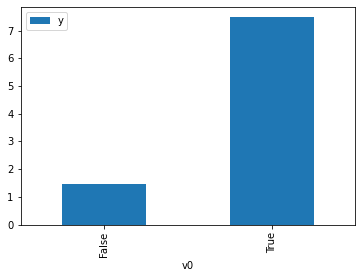

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

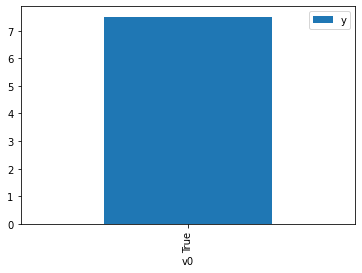

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.377354,False,-2.179725,0.728951,1.371834
1,0.658244,False,2.450426,0.204242,4.896154
2,1.339822,False,4.008301,0.051849,19.286752
3,-1.178950,False,-3.543645,0.943094,1.060340
4,0.775466,False,3.380001,0.164391,6.083054
...,...,...,...,...,...
995,0.476792,False,-0.008731,0.279215,3.581467
996,0.076418,False,0.540386,0.489978,2.040909
997,1.114734,False,3.724939,0.083512,11.974299
998,0.879761,False,3.510798,0.134411,7.439887


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.530887,True,5.832832,0.744802,1.342640
1,0.785266,True,7.059084,0.838640,1.192406
2,0.581882,True,6.089244,0.766161,1.305209
3,0.612638,True,7.821924,0.778428,1.284640
4,2.871021,True,12.262504,0.998307,1.001696
...,...,...,...,...,...
995,0.605350,True,6.438111,0.775564,1.289385
996,0.928937,True,7.858092,0.878047,1.138891
997,1.860863,True,10.730443,0.983507,1.016770
998,0.711692,True,8.810315,0.814759,1.227356


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                          2.824e+04
Date:                Thu, 18 Aug 2022   Prob (F-statistic):                        0.00
Time:                        14:56:39   Log-Likelihood:                         -1428.4
No. Observations:                1000   AIC:                                      2861.
Df Residuals:                     998   BIC:                                      2871.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8657      0.041     70.657      0.000       2.786       2.945
x2             4.9248      0.061     80.611      0.000       4.805       5.045
==============================================================================
Omnibus:                        8.065   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                7.157
Skew:                           0.148   Prob(JB):                       0.0279
Kurtosis:                       2.710   Cond. No.                         3.29
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""